# **Clinical Esophageal Cancer Status Prediction**

## Dataset Overview
This project utilizes the Esophageal Cancer Clinical Dataset. The goal is to predict the Neoplasm Cancer Status (e.g., "WITH TUMOR" vs. "TUMOR FREE") of a patient based on various clinical biomarkers and patient history.

## Workflow
1.  **Data Ingestion:** Loading clinical CSV data.
2.  **Preprocessing:** Cleaning missing values, dropping ID columns, and Label Encoding.
3.  **Visualization:** Analyzing target class balance.
4.  **Modeling:** A Neural Network with Regularization (L2) and Dropout to prevent overfitting.
5.  **Evaluation:** Visualizing Loss/Accuracy curves, Confusion Matrices, and detailed prediction tables.

### Cell 01: Library Imports

This cell imports all necessary libraries for data manipulation (pandas), visualization (seaborn, matplotlib), machine learning (sklearn), and deep learning (tensorflow). We also set the visual style for the plots.

In [3]:
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import os
import joblib
import numpy as np
import pandas as pd
import tqdm.keras
from tqdm.keras import TqdmCallback

# Set Global Visual Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("All Libraries have been imported successfully!")

All Libraries have been imported successfully!


### Cell 02: Load and Inspect Data

Here we load the dataset from the specified path. We display the shape of the data and the first 5 rows to understand the feature structure.

In [4]:
file_path = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Data\Clinical\Esophageal_Dataset.csv"

# Load Data
df = pd.read_csv(file_path)

print(f"Dataset Loaded. Total Records: {df.shape[0]}, Total Features: {df.shape[1]}")

# Display First 5 Rows
print("\nFirst 5 Rows of Dataset")
display(df.head())

Dataset Loaded. Total Records: 3985, Total Features: 85

First 5 Rows of Dataset


,Unnamed: 0,patient_barcode,tissue_source_site,patient_id,bcr_patient_uuid,informed_consent_verified,icd_o_3_site,icd_o_3_histology,icd_10,tissue_prospective_collection_indicator,...,primary_pathology_lymph_node_examined_count,primary_pathology_number_of_lymphnodes_positive_by_he,primary_pathology_number_of_lymphnodes_positive_by_ihc,primary_pathology_planned_surgery_status,primary_pathology_treatment_prior_to_surgery,primary_pathology_residual_tumor,primary_pathology_karnofsky_performance_score,primary_pathology_eastern_cancer_oncology_group,primary_pathology_radiation_therapy,primary_pathology_postoperative_rx_tx
0,0,TCGA-2H-A9GF,2H,A9GF,0500F1A6-A528-43F3-B035-12D3B7C99C0F,YES,C15.5,8140/3,C15.5,NO,...,8.0,7.0,0.0,NaN,NaN,R1,NaN,NaN,NO,NO
1,1,TCGA-2H-A9GG,2H,A9GG,70084008-697D-442D-8F74-C12F8F598570,YES,C15.5,8140/3,C15.5,NO,...,19.0,4.0,0.0,NaN,NaN,R1,NaN,NaN,NO,NO
2,2,TCGA-2H-A9GH,2H,A9GH,606DC5B8-7625-42A6-A936-504EF25623A4,YES,C15.5,8140/3,C15.5,NO,...,30.0,1.0,0.0,NaN,NaN,R0,NaN,NaN,NO,NO
3,3,TCGA-2H-A9GI,2H,A9GI,CEAF98F8-517E-457A-BF29-ACFE22893D49,YES,C15.5,8140/3,C15.5,NO,...,8.0,4.0,0.0,NaN,NaN,R0,NaN,NaN,NO,NO
4,4,TCGA-2H-A9GJ,2H,A9GJ,EE47CD59-C8D8-4B1E-96DB-91C679E4106F,YES,C15.5,8140/3,C15.5,NO,...,19.0,0.0,0.0,NaN,NaN,R0,NaN,NaN,NO,NO


### Cell 03: Data Cleaning & Preprocessing

In this step we:

    - Remove non-predictive columns (IDs).
    - Drop rows with missing targets.
    - Fill missing values (Mode for text, Median for numbers).
    - Encode text labels into numbers.
    - Scale features and split into Train/Test sets.

In [5]:
# 1. DROP NON-PREDICTIVE COLUMNS
columns_to_drop = [
    'Unnamed: 0', 'patient_id', 'bcr_patient_uuid',
    'patient_barcode', 'tissue_source_site', 'icd_10',
    'bcr_patient_barcode', 'identifier'
]
df_clean = df.drop(columns=[c for c in columns_to_drop if c in df.columns], errors='ignore')

# 2. HANDLE TARGET VARIABLE
target_column = 'person_neoplasm_cancer_status'
df_clean = df_clean.dropna(subset=[target_column]) # Drop rows where target is unknown

# 3. FILL MISSING VALUES
df_clean = df_clean.dropna(axis=1, how='all')

for col in df_clean.columns:
    if df_clean[col].nunique() <= 1:    # Drop columns with only 1 unique value (no information)
        df_clean.drop(columns=[col], inplace=True)
    elif col in df_clean.columns:       # Fill remaining
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 4. LABEL ENCODING (Text -> Numbers)
label_encoders = {}
target_encoder = None

for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        if col == target_column:
            target_encoder = le

# 5. SPLIT & SCALE
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Preprocessing Complete.")
print(f"Training Features: {X_train.shape}")
print(f"Testing Features:  {X_test.shape}")

Preprocessing Complete.
Training Features: (2920, 67)
Testing Features:  (730, 67)


### Cell 04: Target Class Distribution Visualization

Before training, we check the balance of our target classes. This helps ensure the model isn't biased toward one outcome.

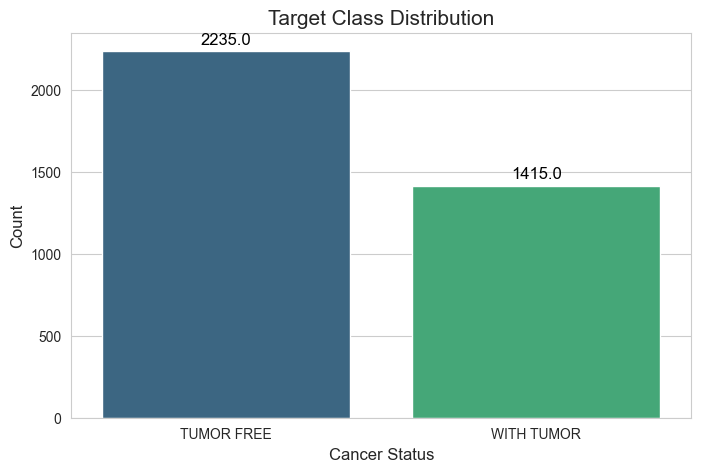

In [6]:
# Get original class names for the plot labels
if target_encoder:
    class_names = target_encoder.inverse_transform([0, 1])
else:
    class_names = [0, 1]

plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y, palette='viridis')

plt.title('Target Class Distribution', fontsize=15)
plt.xlabel('Cancer Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(class_names)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Cell 05: Model Architecture Definition

We define a feed-forward Neural Network.

    - Regularization (L2): Keeps weights small to prevent overfitting.
    - Dropout: Randomly disables neurons during training to force the model to learn robust features.
    - Summary Table: Displays the layers and parameters.

In [7]:
# Define Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),

    # Layer 1: Regularization + High Dropout
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),

    # Layer 2
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),

    # Output Layer: Sigmoid for Binary Classification
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display Model Architecture Table
print("Deep Learning Model Summary")
model.summary()

Deep Learning Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,721 (10.63 KB)

 Trainable params: 2,721 (10.63 KB)

 Non-trainable params: 0 (0.00 B)

### Cell 06: Model Training

We use EarlyStopping to stop training if the model stops improving and ReduceLROnPlateau to adjust the learning rate dynamically.

In [9]:
# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

tqdm_callback = TqdmCallback(verbose=1)

print("Starting Training...")

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, tqdm_callback],
    verbose=0
)

print("\nTraining Complete.")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Starting Training...
Restoring model weights from the end of the best epoch: 100.

Training Complete.


### Cell 07: Performance Visualization

Visualizing the learning curves for loss and accuracy of training and validation.

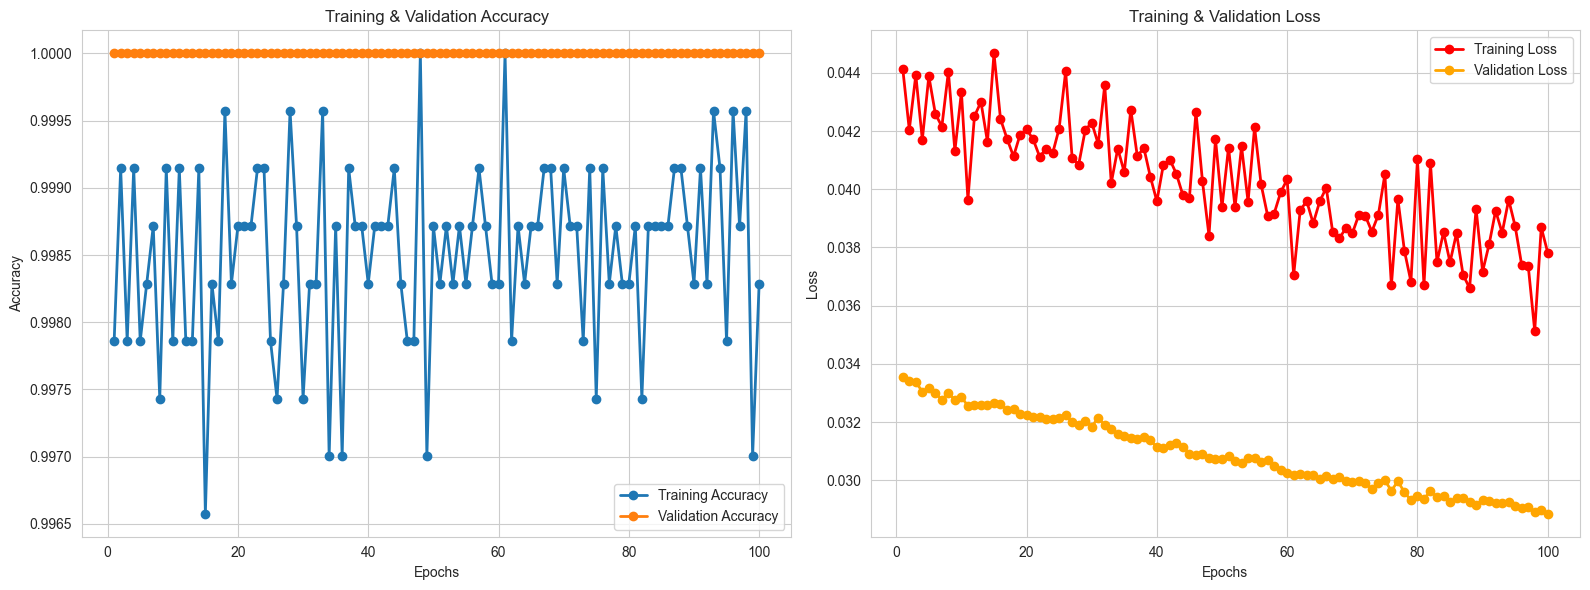

Final Training Accuracy:   0.9983
Final Validation Accuracy: 1.0000


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
ax1.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, marker='o')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, marker='o')
ax1.set_title('Training & Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot Loss
ax2.plot(epochs_range, loss, label='Training Loss', linewidth=2, marker='o', color='red')
ax2.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, marker='o', color='orange')
ax2.set_title('Training & Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy:   {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

### Cell 08: Classification Report
We evaluate the model on the Test Set. We output a Classification Report detailing Precision, Recall, and F1-Score.

In [11]:
# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate Test Accuracy
test_acc = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {test_acc*100:.2f}%\n")

# Classification Report
if target_encoder:
    target_names = target_encoder.inverse_transform([0, 1])
else:
    target_names = ['Class 0', 'Class 1']

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names))

Test Set Accuracy: 100.00%

Classification Report
              precision    recall  f1-score   support

  TUMOR FREE       1.00      1.00      1.00       433
  WITH TUMOR       1.00      1.00      1.00       297

    accuracy                           1.00       730
   macro avg       1.00      1.00      1.00       730
weighted avg       1.00      1.00      1.00       730



### Cell 09: Confusion Matrix

This heatmap visualizes where the model made errors:

    - Diagonal: Correct predictions.
    - Off-diagonal: Incorrect predictions.

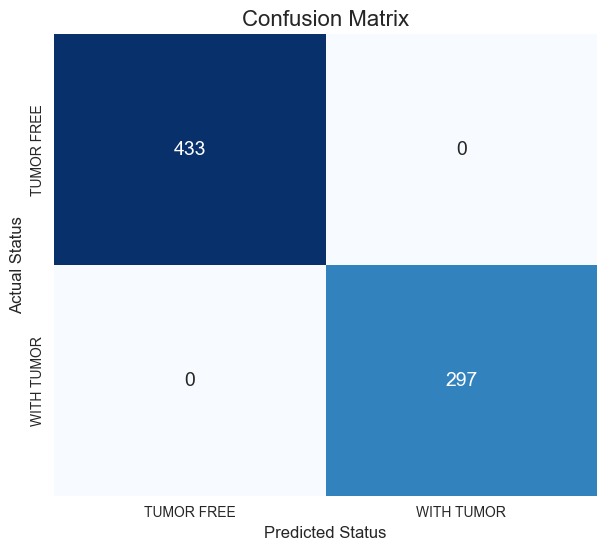

In [12]:
# Generate Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names, annot_kws={"size": 14})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Status', fontsize=12)
plt.xlabel('Predicted Status', fontsize=12)
plt.show()

### Cell 10: Prediction Analysis

Here we create a table showing 10 samples the model got Right and 5 samples it got Wrong (if any exist).

In [13]:
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Actual_Code': y_test.values,
    'Predicted_Code': y_pred
})

# Map codes back to text labels if encoder exists
if target_encoder:
    results_df['Actual_Label'] = target_encoder.inverse_transform(results_df['Actual_Code'])
    results_df['Predicted_Label'] = target_encoder.inverse_transform(results_df['Predicted_Code'])

# Separate Correct and Incorrect
correct_preds = results_df[results_df['Actual_Code'] == results_df['Predicted_Code']]
incorrect_preds = results_df[results_df['Actual_Code'] != results_df['Predicted_Code']]

# Display 10 Correct Predictions
print("\nTop 10 Correct Predictions")
if target_encoder:
    display(correct_preds[['Actual_Label', 'Predicted_Label']].head(10))
else:
    display(correct_preds.head(10))

# Display 5 Incorrect Predictions
print("\nTop 5 Incorrect Predictions")
if incorrect_preds.empty:
    print("Amazing! There are no incorrect predictions in the test set.")
else:
    if target_encoder:
        display(incorrect_preds[['Actual_Label', 'Predicted_Label']].head(5))
    else:
        display(incorrect_preds.head(5))


Top 10 Correct Predictions


,Actual_Label,Predicted_Label
0,WITH TUMOR,WITH TUMOR
1,TUMOR FREE,TUMOR FREE
2,TUMOR FREE,TUMOR FREE
3,TUMOR FREE,TUMOR FREE
4,TUMOR FREE,TUMOR FREE
5,WITH TUMOR,WITH TUMOR
6,WITH TUMOR,WITH TUMOR
7,TUMOR FREE,TUMOR FREE
8,TUMOR FREE,TUMOR FREE
9,WITH TUMOR,WITH TUMOR



Top 5 Incorrect Predictions
Amazing! There are no incorrect predictions in the test set.


### Cell 11: Save Model & Results

Here we are saving the trained model and it's results for later use.

In [14]:
# 1. Configuration - Using Absolute Paths
MODELS_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models"
REPORTS_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Reports"

# Ensure directories exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

# Define Model Architecture Name
MODEL_ARCH = "NeuralNetwork"

# Define Filenames
model_filename = f"Clinical_Model_{MODEL_ARCH}.keras"
report_filename = f"Clinical_Report_{MODEL_ARCH}.txt"
scaler_filename = f"Clinical_Scaler_{MODEL_ARCH}.pkl"
encoder_filename = f"Clinical_Encoder_{MODEL_ARCH}.pkl"

# Full Paths
model_save_path = os.path.join(MODELS_DIR, model_filename)
report_save_path = os.path.join(REPORTS_DIR, report_filename)
scaler_save_path = os.path.join(MODELS_DIR, scaler_filename)
encoder_save_path = os.path.join(MODELS_DIR, encoder_filename)

# 2. Save the Model and Preprocessing Artifacts
print(f"Saving model artifacts to: {MODELS_DIR}...")

# Save Keras Model
model.save(model_save_path)

# Save Scaler (Required for tabular data)
if 'scaler' in globals():
    joblib.dump(scaler, scaler_save_path)

# Save Encoder (Required for decoding predictions)
if 'target_encoder' in globals() and target_encoder:
    joblib.dump(target_encoder, encoder_save_path)

print("✅ Model, Scaler, and Encoder saved successfully.")

# 3. Generate Predictions for the Report
print("Generating predictions for report...")
# Note: Using X_test/y_test for Clinical (Tabular) data
predictions = model.predict(X_test, verbose=0)
y_pred_probs = predictions.flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# 4. Calculate Metrics
# Calculate Loss and Accuracy
eval_results = model.evaluate(X_test, y_test, verbose=0)
test_loss = eval_results[0]
test_acc = eval_results[1]

# Calculate AUC (using sklearn)
try:
    test_auc = roc_auc_score(y_test, y_pred_probs)
except:
    test_auc = 0.0 # Handle case if only one class is present

# Get Class Names
if 'target_encoder' in globals() and target_encoder:
    class_names = [str(cls) for cls in target_encoder.classes_]
else:
    class_names = ['Class 0', 'Class 1']

class_report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)

# 5. Construct Report Content
report_content = f"""Clinical Model Evaluation Report
=========================================
Model Name:      {model_filename}
Architecture:    {MODEL_ARCH}
Input Features:  {X_test.shape[1]}
=========================================

Overall Metrics:
----------------
Test Accuracy : {test_acc*100:.2f}%
Test AUC      : {test_auc:.4f}
Test Loss     : {test_loss:.4f}

Classification Report:
----------------------
{class_report}

Confusion Matrix:
-----------------
{conf_matrix}
"""

# 6. Save Report to File
print(f"Saving report to: {report_save_path}...")
with open(report_save_path, "w") as f:
    f.write(report_content)

print("✅ Report saved successfully.")
print("\n--- Report Preview ---")
print(report_content)

Saving model artifacts to: E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models...
✅ Model, Scaler, and Encoder saved successfully.
Generating predictions for report...
Saving report to: E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Reports\Clinical_Report_NeuralNetwork.txt...
✅ Report saved successfully.

--- Report Preview ---
Clinical Model Evaluation Report
Model Name:      Clinical_Model_NeuralNetwork.keras
Architecture:    NeuralNetwork
Input Features:  67

Overall Metrics:
----------------
Test Accuracy : 100.00%
Test AUC      : 1.0000
Test Loss     : 0.0290

Classification Report:
----------------------
              precision    recall  f1-score   support

  TUMOR FREE       1.00      1.00      1.00       433
  WITH TUMOR       1.00      1.00      1.00       297

    accuracy                           1.00       730
   macro avg       1.00      1.00      1.00       730
weighted avg       1.00      1.00      1.00       730


Confusion Matrix:
-----------------
[[433   0]
 [

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Calculating SHAP values... this might take a minute.


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6813/6813 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━

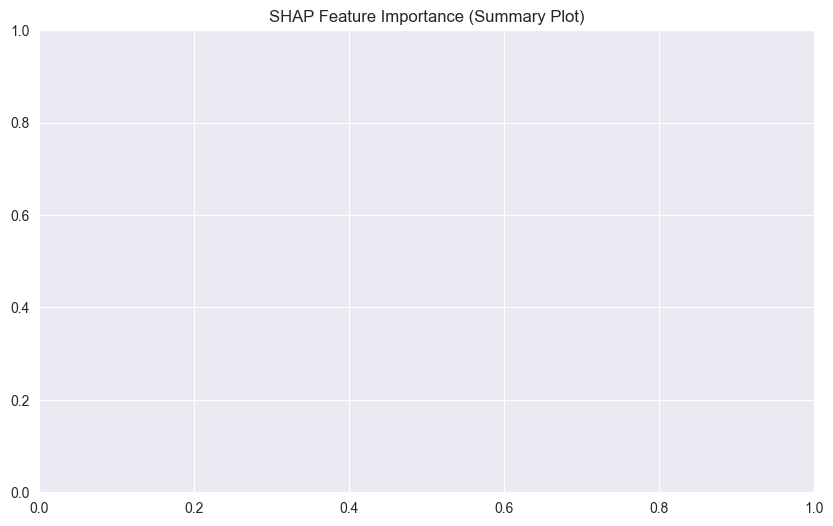

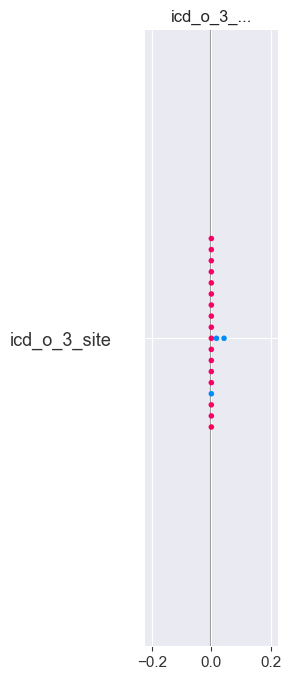

In [13]:
# Cell: SHAP Explanation
import shap

# 1. Initialize JS for plots
shap.initjs()

# 2. Setup Explainer
# We use a summary of the training data (background) to estimate expectations.
# Using a small background sample (e.g., 50-100 rows) speeds up the calculation significantly.
background = X_train[:100]
explainer = shap.KernelExplainer(model.predict, background)

# 3. Calculate SHAP values for a subset of the test set
# (Calculating for the whole test set might take too long with KernelExplainer)
print("Calculating SHAP values... this might take a minute.")
shap_values = explainer.shap_values(X_test[:20])

# 4. Handle List output (common in Keras/TensorFlow models)
# If shap_values is a list, take the first element (for the single output node)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 5. Summary Plot (Beeswarm)
plt.figure()
plt.title("SHAP Feature Importance (Summary Plot)")
shap.summary_plot(shap_values, X_test[:20], feature_names=X.columns)

In [15]:
!pip install lime

  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached networkx-3.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Cell: LIME Explanation
import lime
from lime import lime_tabular
import numpy as np

# 1. Define a Wrapper Function for Prediction
# LIME expects probabilities for both classes [Prob(Class0), Prob(Class1)],
# but your Sigmoid model outputs only [Prob(Class1)]. This wrapper fixes that.
def predict_proba_wrapper(data):
    pred = model.predict(data, verbose=0)
    return np.hstack((1 - pred, pred)) # Returns shape (N, 2)

# 2. Create the LIME Explainer
# We pass the training data statistics and feature names
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns.tolist(),
    class_names=['Tumor Free', 'With Tumor'], # Class 0, Class 1
    mode='classification'
)

# 3. Explain a Specific Instance
# Let's pick a random patient from the test set (e.g., index 5)
idx = 5
patient_data = X_test[idx]

print(f"Explaining prediction for Patient #{idx}")
explanation = explainer_lime.explain_instance(
    data_row=patient_data,
    predict_fn=predict_proba_wrapper,
    num_features=10 # Show top 10 contributing features
)

# 4. Display the explanation
# If running in Jupyter:
explanation.show_in_notebook(show_table=True)

# If you want to save it as an HTML file to view later:
# explanation.save_to_file('lime_patient_explanation.html')